# Midterm Mapping

To build upon mapping Land Cover from the National Land Cover Database I have explored using numpy masked arrays as well as contextily basemaps to overlay different years of the landcover database to convey change over time.

First we will pull in the data we need for the first and last years we have: 2004 and 2019, then we can map those side by side.

Afterwords we can calculate the differences between them. 

In [1]:
#import necessary packages
# Rasterio documentation can be found at https://rasterio.readthedocs.io/en/latest/

import numpy as np
import rasterio
import rasterio.plot
import pandas as pd


# import plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

import contextily as ctx

In [2]:
years = [2004, 2019] # create a list of the comparison years to loop over
data = {} # Create an empty dictionary to save the raster dataset to 
data_masked = {} # Create empty dictionary to save masked numpy array to

In [3]:
#Loop through years specified to create data needed to plot
for year in years:
    data[year] = rasterio.open(f'data/NLCD/NLCD_{str(year)}_Land_Cover_L48_20210604_gyGbthZM9gweVLuKaW5e.tiff') # open raster and create element in 'data' dict.
    data_masked[year] = np.ma.masked_where(data[year].read(1)!=11, data[year].read(1)) # mask raster to show only were data is '11' (Open Water)

### Mapping Change in Water Cover

Now that we have our data prepared and masked we can overlay the 2004 and 2019 data we can overlay them to highlight the areas where there used to be water but is now dry lakebed.

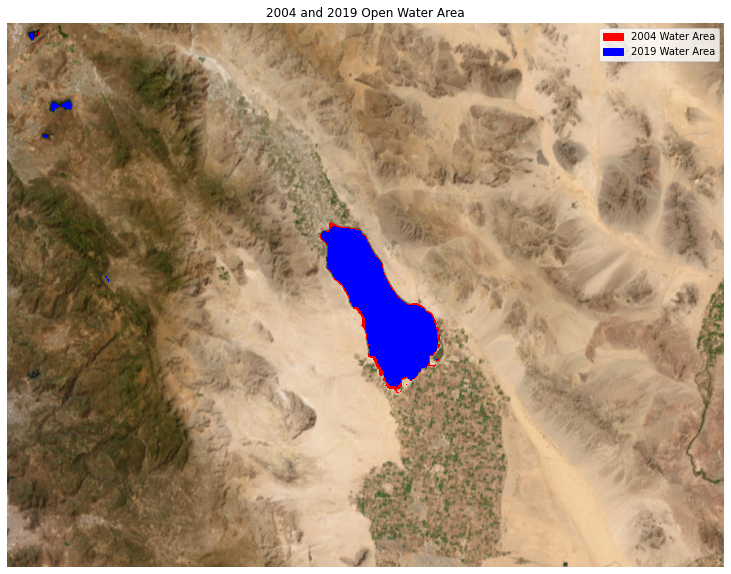

In [27]:
fig, ax = plt.subplots(figsize=(15,10)) # create a figure and axis object to map onto and set the figure size.
plt.imshow(data_masked[years[1]], extent=rasterio.plot.plotting_extent(data[years[1]]), cmap=ListedColormap(['blue']), zorder= 15) #plot data, set extent to geography, set color and drawing order
plt.imshow(data_masked[years[0]], extent=rasterio.plot.plotting_extent(data[years[0]]), cmap=ListedColormap(['red']), zorder= 10)

# creates legend items
handles = [
    Patch(color='red', label='2004 Water Area'),
    Patch(color='blue', label='2019 Water Area')
]

ctx.add_basemap(ax, crs=dataset_2019.read_crs(), source=ctx.providers.Esri.WorldImagery, zorder=5)
plt.axis('off')
plt.title('2004 and 2019 Open Water Area')
ax.legend(handles=handles)

plt.show()

This highlights the significant change in water area of the Salton Sea over this time period, but can we quantify it? 

We can with some numpy calculations! The individual pixel/cell size from NLCD is 30m by 30m, and we can count the number of cells of water in each year and calculate the difference.

In [4]:
count_19 = np.count_nonzero(data[2019].read(1) == 11)
count_04 = np.count_nonzero(data[2004].read(1) == 11)

sq_km = (count_04 - count_19)*900/1e6

print(f'The area surface area of water lost between 2004 and 2019 was {sq_km} square kilometers.')

The area surface area of water lost between 2004 and 2019 was 68.4603 square kilometers.


That doesn't sound like a ton off the bat, but in perspective that is 12,793 football fields of area! That is a ton of water lost, and a ton of exposed dust and desert.

Now let's make a graph to see the land cover area for all categories side by side.

In [7]:
# Open the data dictionary and save it as a normal python dictionary for 

data_dict = pd.read_csv('data/NLCD/NLCD_landcover_legend_2018_12_17_gyGbthZM9gweVLuKaW5e.csv')
data_dict.dropna(axis=0, inplace=True) # Drop values with no legend information
legend = dict(zip(data_dict['Value'], data_dict['Legend'])) # save values and legend item as a dictionary for ease of use later.

In [8]:
# Create numpy arrays that are labeled instead of just as integers
labeled_data = {} #create an empty dict to fill
for year in years:
    labeled_data[year] = np.vectorize(legend.get)(data[year].read(1)) # fill dict item with np array where elements are labeled strings

In [9]:
# count cells of each land cover type for each year
counts_04 = np.unique(labeled_data[2004], return_counts=True)
counts_19 = np.unique(labeled_data[2019], return_counts=True)

In [11]:
# Create dataframe with landcover type and count for each year
df = pd.DataFrame(list(zip(counts_04[0],counts_04[1], counts_19[1])), columns=['landcover', '2004', '2019']) 
df['2004'] = df['2004']*900/1e6 # calculate as area in sq km
df['2019'] = df['2019']*900/1e6
df.head()

,landcover,2004,2019
0,Barren Land,6903.8847,6761.5686
1,Cultivated Crops,2445.0894,2430.3978
2,Deciduous Forest,1.5948,1.0548
3,"Developed, High Intensity",89.3592,129.3219
4,"Developed, Low Intensity",465.2577,497.9142


In [13]:
df_long = pd.melt(df, id_vars='landcover', value_vars=['2004','2019']) # convert to a "long" data frame that is better for plotting side by side

<bound method _AxesBase.get_xaxis of <AxesSubplot:xlabel='Land Cover', ylabel='Area of Land (square km)'>>

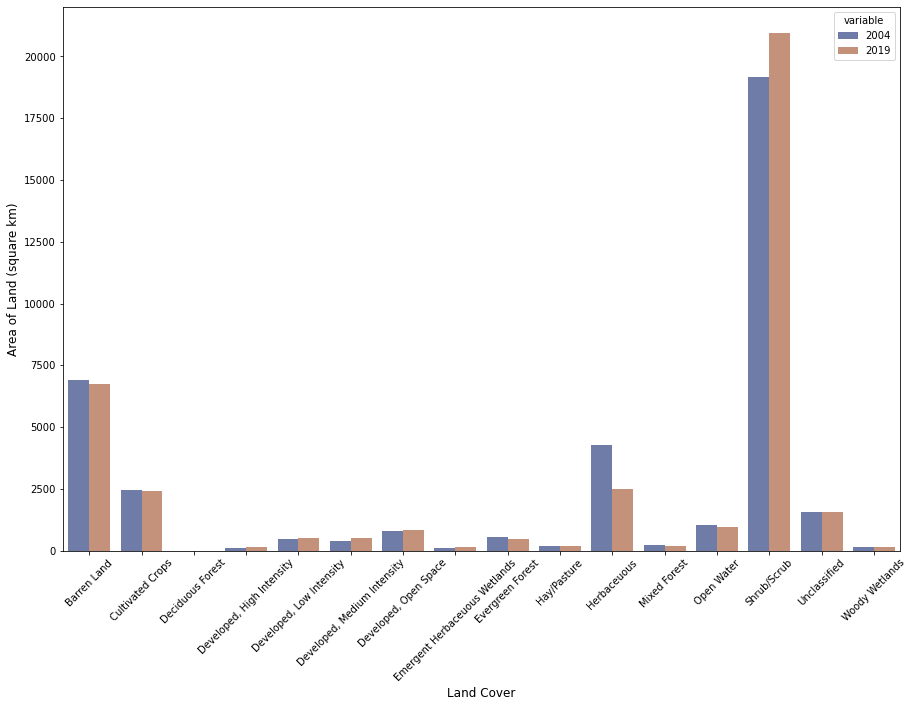

In [16]:
# Plot the land cover area as a bar chart side by side
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,10))

sns.barplot( 
    ax=ax, data=df_long,
    x='landcover', y='value', hue='variable',
    palette='dark', alpha=.6,
)
plt.xlabel('Land Cover', fontsize=12)
plt.ylabel('Area of Land (square km)', fontsize=12)
plt.xticks(rotation=45)
ax.get_xaxis

While the differences between the land cover types are slight overall there are small but meaningful changes in Open water (as shown earlier), as well as the area of cultivated crops. There are also slight increases in developed spaces. 